# Mask R-CNN - Inspect Carton Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

from samples.carton import carton

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to Ballon trained weights
# You can download this file from the Releases page
# https://github.com/matterport/Mask_RCNN/releases
CARTON_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_carton_0030.h5")

Using TensorFlow backend.


## Configurations

In [2]:
config = carton.CartonConfig()
CARTON_DIR = os.path.join(ROOT_DIR, "datasets/carton")

In [3]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Notebook Preferences

In [4]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [5]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [9]:
# Load validation dataset
dataset = carton.CartonDataset()
# dataset.load_carton(CARTON_DIR, "new_images")
dataset.load_carton(CARTON_DIR, "val")
# dataset.load_carton(CARTON_DIR, "real_carton_imgs/1img")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 8
Classes: ['BG', 'green_front', 'green_back']


## Load Model

In [10]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

In [11]:
# Set path to balloon weights file

# Download file from the Releases page and set its path
# https://github.com/matterport/Mask_RCNN/releases
weights_path = CARTON_WEIGHTS_PATH

# Or, load the last model you trained
#weights_path = model.find_last()

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /home/qxuaj/Desktop/carton_perception/Mask_RCNN/mask_rcnn_carton_0030.h5


## Run Detection

In [91]:
# image_id = random.choice(dataset.image_ids)
# image_id = 5
# image, image_meta, gt_class_id, gt_bbox, gt_mask =\
#     modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
# info = dataset.image_info[image_id]
# print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
#                                        dataset.image_reference(image_id)))

import scipy
img_index = 1
image =  scipy.misc.imread('/home/qxuaj/Desktop/carton_perception/Mask_RCNN/datasets/carton/imgs_for_erecting/'+ str(img_index) +'.jpg')

/home/qxuaj/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # This is added back by InteractiveShellApp.init_path()


Processing 1 images
image                    shape: (1080, 1440, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  145.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1440.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


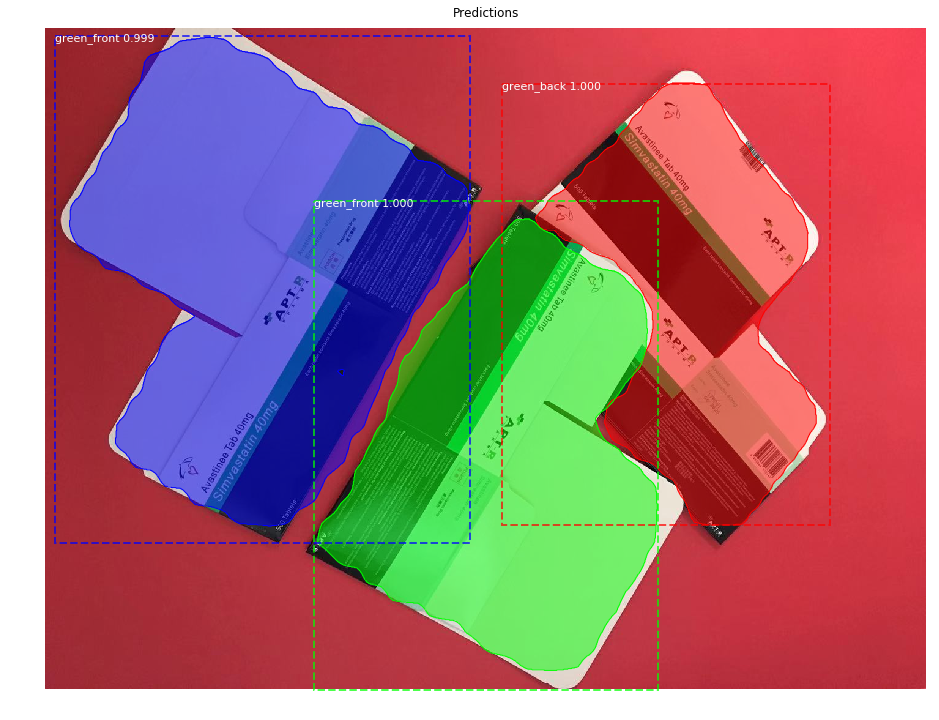

In [28]:
# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")

In [29]:
#return the id of mask which have the max area
def get_max_area_mask(masks):
    #get the number of masks
    mask_num = masks.shape[2]
    
    largest_mask_idx = 0
    largest_mask_area = 0
    for index in range(mask_num):        
        mask = r['masks'][:,:,index]
        
        #get the area of masks[index]
        temp_mask_pixel_sum = 0
        for row in mask:
            temp_mask_pixel_sum += sum(row)
        
        #compare the result with the 
        if (temp_mask_pixel_sum > largest_mask_area):
            largest_mask_area = temp_mask_pixel_sum
            largest_mask_idx = index
    
    return largest_mask_idx

The largest area img is : 2


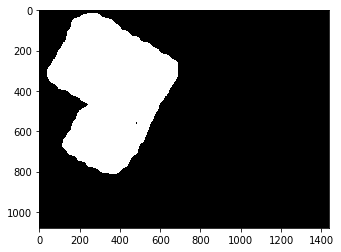

In [30]:
index = get_max_area_mask(r['masks'])
                  
print("The largest area img is :", index)
plt.imshow(r['masks'][:,:,index], cmap='gray')

plt.show() 


255


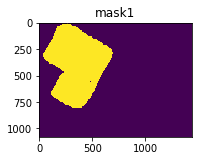

In [31]:
try:
    sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
except:
    'remove python 2.7 kinetic folder to make cv2 library importable'

import cv2
import numpy as np
from matplotlib import pyplot as plt
import scipy.io as sio


#import the mask information of Region of Interests
# mat_contents = r['masks'];
mask = r['masks'];

mask1 = mask[:, :, index] * 255;
mask1 = np.uint8(mask1)
print((mask1.max()))    

plt.subplot(1, 2, 1)
plt.imshow(mask1)
plt.title('mask1')


# plt.subplot(1, 2, 2)
# plt.imshow(mask2)
# plt.title('mask2')

plt.show()

Text(0.5, 1.0, 'Edge Image After Eroding')

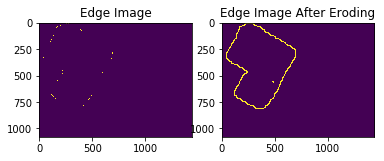

In [32]:
#use canny() function to generate edge image
edge_image = cv2.Canny(mask1, 50, 150, apertureSize=3)
img_bw = edge_image

plt.subplot(1, 2, 1)
plt.imshow(img_bw)
plt.title('Edge Image')

#after eroding
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(9, 9))
img_bw_eroded = cv2.dilate(img_bw, kernel)

plt.subplot(1, 2, 2)
plt.imshow(img_bw_eroded)
plt.title('Edge Image After Eroding')


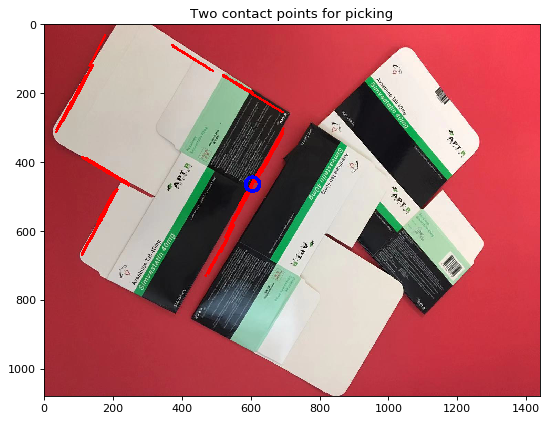

In [33]:
import math

#TARGET: find out contact point for robot picking

#the contact point is supposed to be the center of the longest line

#follow the opencv tutorial
#detect all lines in edge image with function HoughLinesP()
minLineLength = 80
maxLineGap = 10
lines = cv2.HoughLinesP(img_bw_eroded, 1, np.pi / 180, 100, maxLineGap, minLineLength)

#draw lines on the original image
output = image.copy()
index_count = 0
max_segment_length = 0
max_segment_length_index = 0
for line in lines:
    for x1, y1, x2, y2 in line:
        cv2.line(output, (x1, y1), (x2, y2), 255, 5)
        
        #find out the index of the longest line
        segment_length = math.sqrt((x2 - x1)*(x2 - x1) + (y2 - y1)*(y2 - y1))
        if (segment_length > max_segment_length):
            max_segment_length = segment_length
            max_segment_length_index = index_count
            
        index_count += 1


#calculate the center point of the longest line
longest_line_x1 = lines[max_segment_length_index][0][0]
longest_line_y1 = lines[max_segment_length_index][0][1]
longest_line_x2 = lines[max_segment_length_index][0][2]
longest_line_y2 = lines[max_segment_length_index][0][3]

center_point_x = int((longest_line_x1 + longest_line_x2)/2)
center_point_y = int((longest_line_y1 + longest_line_y2)/2)


#draw a circle to show the center point
cv2.circle(output, (center_point_x, center_point_y), 20, (0, 0, 255), 10)

plt.figure(figsize=(8,8),dpi=80)
plt.imshow(output)
plt.title('Two contact points for picking', )
plt.show()


In [34]:
#get largetest area index
index = get_max_area_mask(r['masks'])
print("The largest area img is :", index)

#save largest area mask to mask1 variable
mask = r['masks'];
mask1 = np.uint8(mask[:, :, index] * 255);

#use canny() function to generate edge image
edge_image = cv2.Canny(mask1, 50, 150, apertureSize=3)
img_bw = edge_image

#Do eroding for further line detection
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(9, 9))
img_bw_eroded = cv2.dilate(img_bw, kernel)



The largest area img is : 2


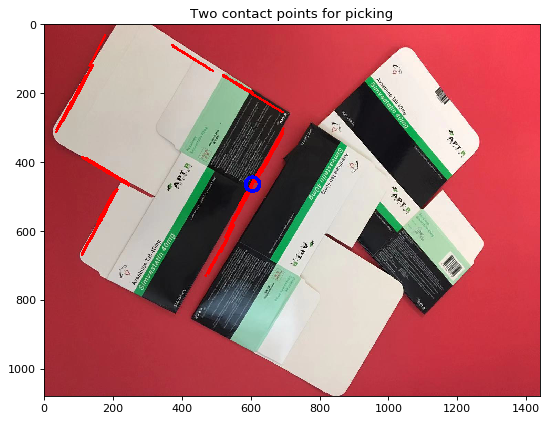

In [35]:
#TARGET: find out contact point for robot picking

#the contact point is supposed to be the center of the longest line

#follow the opencv tutorial
#detect all lines in edge image with function HoughLinesP()
minLineLength = 80
maxLineGap = 10
lines = cv2.HoughLinesP(img_bw_eroded, 1, np.pi / 180, 100, maxLineGap, minLineLength)

#draw lines on the original image
output = image.copy()
index_count = 0
max_segment_length = 0
max_segment_length_index = 0
for line in lines:
    for x1, y1, x2, y2 in line:
        cv2.line(output, (x1, y1), (x2, y2), 255, 5)
        
        #find out the index of the longest line
        segment_length = math.sqrt((x2 - x1)*(x2 - x1) + (y2 - y1)*(y2 - y1))
        if (segment_length > max_segment_length):
            max_segment_length = segment_length
            max_segment_length_index = index_count
            
        index_count += 1


#calculate the center point of the longest line
longest_line_x1 = lines[max_segment_length_index][0][0]
longest_line_y1 = lines[max_segment_length_index][0][1]
longest_line_x2 = lines[max_segment_length_index][0][2]
longest_line_y2 = lines[max_segment_length_index][0][3]

center_point_x = int((longest_line_x1 + longest_line_x2)/2)
center_point_y = int((longest_line_y1 + longest_line_y2)/2)


#draw a circle to show the center point
cv2.circle(output, (center_point_x, center_point_y), 20, (0, 0, 255), 10)

plt.figure(figsize=(8,8),dpi=80)
plt.imshow(output)
plt.title('Two contact points for picking', )
plt.show()


## Use OpenCV approxPolyDP() to Get the Contour


Get the mask with largest area in the results of Mask RCNN detection

In [36]:
#get largetest area index
index = get_max_area_mask(r['masks'])
print("The largest area img is :", index)

#save largest area mask to mask1 variable
mask = r['masks'];
mask1 = np.uint8(mask[:, :, index] * 255);

The largest area img is : 2


This is the mask with largest area in the results of Mask RCNN detection

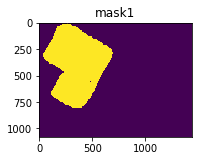

In [37]:
plt.subplot(1, 2, 1)
plt.imshow(mask1)
plt.title('mask1')

plt.show()

Use erode and dilate function to eliminate the noise in the image

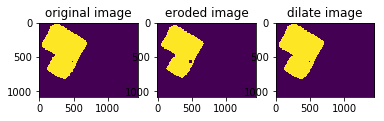

In [190]:
#Set erode and dilate size
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(30, 30))

#Erode and then dilate the image to eliminate the noise
mask_eroded = cv2.erode(mask1, kernel)
mask_dilated = cv2.dilate(mask_eroded, kernel)

plt.subplot(1, 3, 1)
plt.title('original image')
plt.imshow( mask1)

plt.subplot(1, 3, 2)
plt.title('eroded image')
plt.imshow( mask_eroded)


plt.subplot(1, 3, 3)
plt.title('dilate image')
plt.imshow( mask_dilated)

plt.show()

### Contour Approximation 

refer to https://docs.opencv.org/3.1.0/dd/d49/tutorial_py_contour_features.html

Use approxPolyDP() function to get the contour result, adjust parameter with 0.02 in `epsilon = 0.02*cv2.arcLength(cnt,True)` to get a better contour result

In [191]:
ret,thresh = cv2.threshold(mask_dilated,127,255,0)
im2,contours,hierarchy = cv2.findContours(thresh, 1, 2)
cnt = contours[0]

M_carton = cv2.moments(cnt)
cx_carton = int(M_carton['m10']/M_carton['m00'])
cy_carton = int(M_carton['m01']/M_carton['m00'])

In [40]:
epsilon = 0.02*cv2.arcLength(cnt,True)
approx = cv2.approxPolyDP(cnt,epsilon,True)

img = mask1.copy()
cv2.polylines(img, [approx], True, (0, 0, 255), 2)


for point in approx:
    cv2.circle(img, (point[0][0], point[0][1]), 20, (200, 0, 0), 20)
    

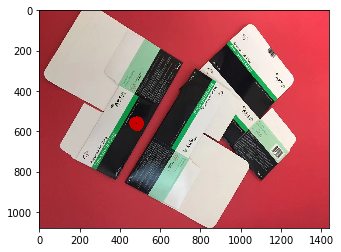

In [43]:
plt.imshow(img)
plt.show()



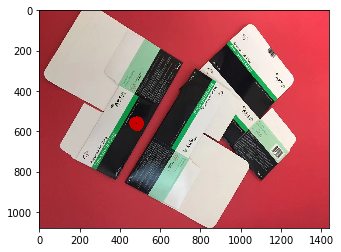

In [44]:
epsilon = 0.02*cv2.arcLength(cnt,True)
approx = cv2.approxPolyDP(cnt,epsilon,True)

img = image.copy()
cv2.polylines(img, [approx], True, (0, 0, 255), 2)

for point in approx:
    cv2.circle(img, (point[0][0], point[0][1]), 20, (200, 0, 0), 20)
plt.imshow(img)
plt.show()

### Find out the segment with largest length

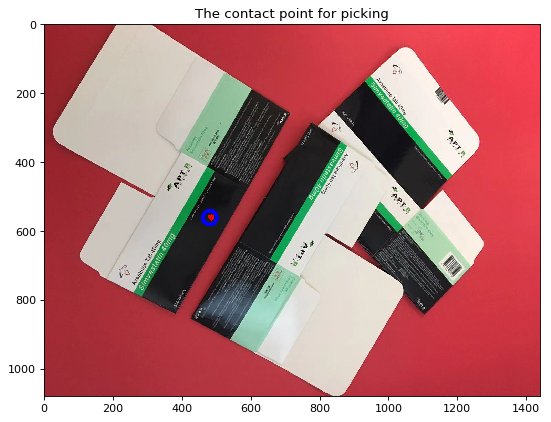

In [45]:
lines = []

#Transform contour points to segmentations
last_point = approx[-1]

for point in approx:
    lines.append([[last_point[0][0], last_point[0][1], point[0][0], point[0][1]]])
    last_point = point


#Find out the longest line
output = image.copy()

index_count = 0
max_segment_length = 0
max_segment_length_index = 0
for line in lines:
    for x1, y1, x2, y2 in line:
        cv2.line(output, (x1, y1), (x2, y2), 255, 5)
        
        #find out the index of the longest line
        segment_length = math.sqrt((x2 - x1)*(x2 - x1) + (y2 - y1)*(y2 - y1))
        if (segment_length > max_segment_length):
            max_segment_length = segment_length
            max_segment_length_index = index_count
            
        index_count += 1


#calculate the center point of the longest line
longest_line_x1 = lines[max_segment_length_index][0][0]
longest_line_y1 = lines[max_segment_length_index][0][1]
longest_line_x2 = lines[max_segment_length_index][0][2]
longest_line_y2 = lines[max_segment_length_index][0][3]

center_point_x = int((longest_line_x1 + longest_line_x2)/2)
center_point_y = int((longest_line_y1 + longest_line_y2)/2)


#draw a circle to show the center point
cv2.circle(output, (center_point_x, center_point_y), 20, (0, 0, 255), 10)

plt.figure(figsize=(8,8),dpi=80)
plt.imshow(output)
plt.title('The contact point for picking', )
plt.show()

## Use Color Filtering to Localize the Carton

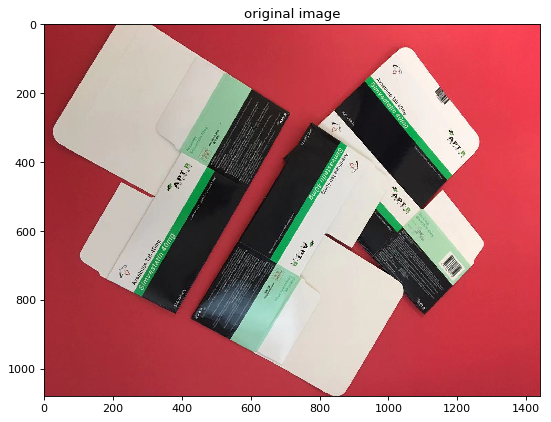

In [50]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import scipy.io as sio

lower_green = np.array([0,80,0])
upper_green = np.array([45,255,255])

green_mask = cv2.inRange(image, lower_green, upper_green)
res = cv2.bitwise_and(image,image, mask= green_mask)

plt.figure(figsize=(8,8),dpi=80)
plt.title('original image')
plt.imshow( image)


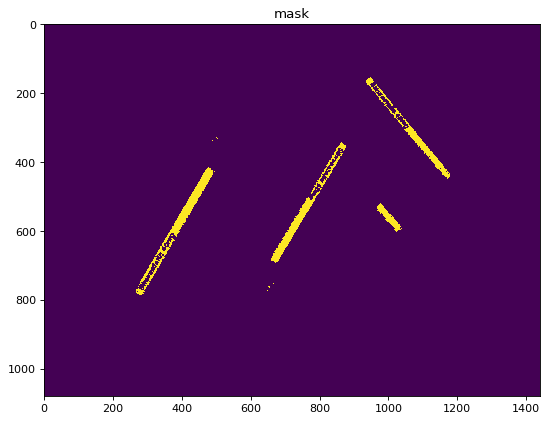

In [53]:
plt.figure(figsize=(8,8),dpi=80)
plt.title('mask')
plt.imshow( green_mask)



## print maximum area carton mask given by Mask RCNN

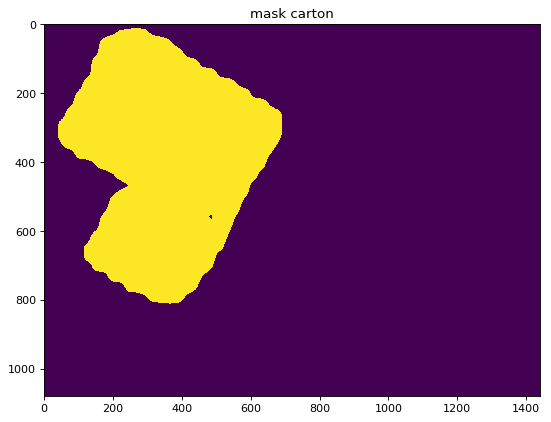

In [57]:
mask = r['masks'];

mask_carton = mask[:, :, index] * 255;
mask_carton = np.uint8(mask_carton)
#print((mask1.max()))    

plt.figure(figsize=(8,8),dpi=80)
plt.imshow(mask_carton)
plt.title('mask carton')

plt.show()

## Use maximum mask to choose the green bar

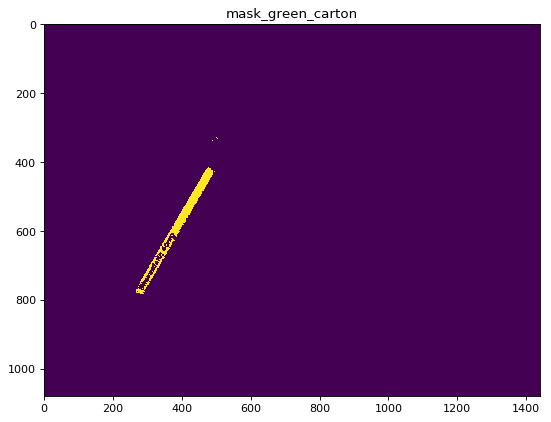

In [136]:
mask_green_carton = cv2.bitwise_and(mask_carton, green_mask)
plt.figure(figsize=(8,8),dpi=80)
plt.imshow(mask_green_carton)
plt.title('mask_green_carton')

plt.show()

## Process the mask for bounding rectangle detection

Text(0.5, 1.0, 'mask_green_carton')

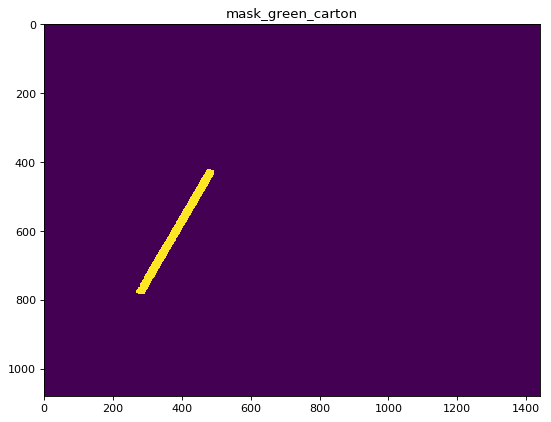

In [221]:
#Set erode and dilate size
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(10, 10))

#dilate and then erode the image to fill the words
mask_dilated = cv2.dilate(mask_green_carton, kernel)
mask_eroded = cv2.erode(mask_dilated, kernel)

#Erode and then dilate the image to eliminate the noise
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(8, 8))
mask_eroded = cv2.erode(mask_eroded, kernel)
mask_green_carton_processed = cv2.dilate(mask_eroded, kernel)

plt.figure(figsize=(8,8),dpi=80)
plt.imshow(mask_green_carton_processed)
plt.title('mask_green_carton')

## Use opencv function minAreaRect to get the bounding reactangle

In [222]:
_, contours,hierarchy = cv2.findContours(mask_green_carton_processed,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
cnt = contours[0]

#calculate center point
M = cv2.moments(cnt)
cx = int(M['m10']/M['m00'])
cy = int(M['m01']/M['m00'])

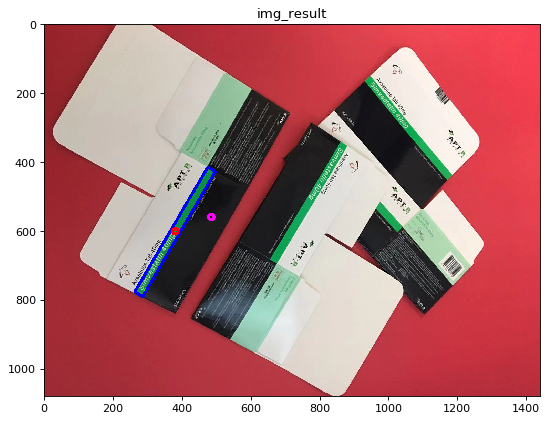

In [223]:
#draw bounding point
rect = cv2.minAreaRect(cnt)
box = cv2.boxPoints(rect)
box = np.int0(box)
img_result = cv2.drawContours(image.copy(),[box],0,(0,0,255),8)

#draw center point
cv2.circle(img_result, (cx, cy), 8, (255, 0, 0), 8)

cv2.circle(img_result, (cx_carton, cy_carton), 8, (255, 0, 255), 8)



plt.figure(figsize=(8,8),dpi=80)
plt.imshow(img_result)
plt.title('img_result')

plt.show()

## Calculate contact point

In [224]:
center_points = [[0, 0], [0, 0], [0, 0], [0, 0]]
center_dist = [[0, 0], [0, 1], [0, 2], [0, 3]]
for i in range(4):
    center_points[i][0] = (box[i][0] + box[(i+1)%4][0]) / 2 
    center_points[i][1] = (box[i][1] + box[(i+1)%4][1]) / 2 
    center_dist[i][0] = math.sqrt((center_points[i][0] - cx)**2 + (center_points[i][1] - cy)**2)
    
#get farest two centers
for i in range(4):
    for j in range(i+1, 4):
        if (center_dist[i][0] < center_dist[j][0]):
            tmp = center_dist[i][0]
            center_dist[i][0] = center_dist[j][0]
            center_dist[j][0] = tmp
            
            tmp = center_dist[i][1]
            center_dist[i][1] = center_dist[j][1]
            center_dist[j][1] = tmp

far_point1_x = int(center_points[center_dist[0][1]][0])
far_point1_y = int(center_points[center_dist[0][1]][1])

far_point2_x = int(center_points[center_dist[1][1]][0])
far_point2_y = int(center_points[center_dist[1][1]][1])

# cv2.circle(img_result, (far_point1_x, far_point1_y), 8, (255, 0, 0), 8)
# cv2.circle(img_result, (far_point2_x, far_point2_y), 8, (255, 0, 0), 8)
print(' ')

In [225]:
dist1 = math.sqrt((far_point1_x - cx_carton)**2 + (far_point1_y - cy_carton)**2)
dist2 = math.sqrt((far_point2_x - cx_carton)**2 + (far_point2_y - cy_carton)**2)

if dist1 < dist2:
    tilt_point_x = int(far_point1_x + (far_point1_x - cx) * (104.0 / 83.5))
    tilt_point_y = int(far_point1_y + (far_point1_y - cy) * (104.0 / 83.5))
    
    fixed_point_x = far_point2_x
    fixed_point_y = far_point2_y
else:
    tilt_point_x = int(far_point2_x + (far_point2_x - cx) * (104.0 / 83.5))
    tilt_point_y = int(far_point2_y + (far_point2_y - cy) * (104.0 / 83.5))
    
    fixed_point_x = far_point1_x
    fixed_point_y = far_point1_y

cv2.circle(img_result, (tilt_point_x, tilt_point_y), 8, (255, 255, 0), 8)
cv2.circle(img_result, (fixed_point_x, fixed_point_y), 8, (0, 255, 0), 8)

print(' ')

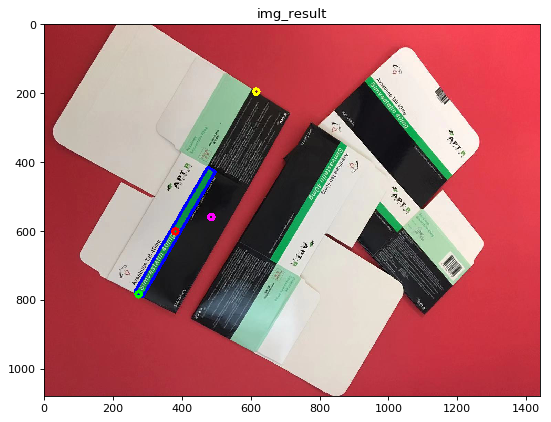

In [226]:
plt.figure(figsize=(8,8),dpi=80)
plt.imshow(img_result)
plt.title('img_result')

plt.show()